This notebook is for EDA on the webNLG dataset. The goal is to reverse engineer the WebNLG syntax for use in our generative data. 

In [1]:
# !conda install transformers
# !conda install sentencepiece

In [2]:
# Misc 
import urllib.request
import zipfile
import glob
import os
import shutil

# Data Science
import pandas as pd
import xml.etree.ElementTree as ET
import torch
import re
from transformers import T5Tokenizer, T5ForConditionalGeneration, Adafactor

# Visualization 
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML, display

# admin
sns.set_style('darkgrid')


# Dataset

In [3]:
##################################################################
# Helper Functions 
##################################################################

def download_and_extract_dataset(url, save_zip_as, extract_to):
    urllib.request.urlretrieve(url, save_zip_as)
    with zipfile.ZipFile(save_zip_as, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

def process_dataset(files):
    triple_re = re.compile('(\d)triples')
    data_dct = {}
    for file in files:
        tree = ET.parse(file)
        root = tree.getroot()
        triples_num = int(triple_re.findall(file)[0])
        for sub_root in root:
            for ss_root in sub_root:
                structured_master = []
                unstructured = []
                for entry in ss_root:
                    unstructured.append(entry.text)
                    structured = [triple.text for triple in entry]
                    structured_master.extend(structured)
                unstructured = [i for i in unstructured if i.replace('\n', '').strip() != '']
                structured_master = structured_master[-triples_num:]
                structured_master_str = (' && ').join(structured_master)
                data_dct[structured_master_str] = unstructured
    return data_dct

def create_dataframe(data_dct):
    mdata_dct = {"prefix": [], "input_text": [], "target_text": []}
    for st, unst in data_dct.items():
        for i in unst:
            mdata_dct['prefix'].append('webNLG')
            mdata_dct['input_text'].append(st)
            mdata_dct['target_text'].append(i)
    df = pd.DataFrame(mdata_dct)
    return df

##################################################################
# Process
##################################################################

# create directory 
DIR_SAVE = './data/webNLG/'
if not os.path.exists(DIR_SAVE):
    os.makedirs(DIR_SAVE)
FILENAME = "webNLG2020_train.csv"
PATH = os.path.join(DIR_SAVE, FILENAME)

# download and extract dataset
url = 'https://gitlab.com/shimorina/webnlg-dataset/-/archive/master/webnlg-dataset-master.zip?path=release_v3.0/en/train'
download_and_extract_dataset(url, 'web.zip', 'web')
files = glob.glob("web/webnlg-dataset-master-release_v3.0-en-train/release_v3.0/en/train/**/*.xml", recursive=True)
data_dct = process_dataset(files)
df = create_dataframe(data_dct)
df.to_csv(PATH)






## EDA

In [4]:
# split a string by | delimiter 
def split_string(string):
    return string.split(' | ')

df["input_sub"] = df["input_text"].apply(split_string).apply(lambda x: x[0])
df["input_vrb"] = df["input_text"].apply(split_string).apply(lambda x: x[1])
df["input_obj"] = df["input_text"].apply(split_string).apply(lambda x: x[2])

display(df.sample(10))

,prefix,input_text,target_text,input_sub,input_vrb,input_obj
33952,webNLG,A_Loyal_Character_Dancer | language | English_...,A Loyal Character Dancer is published by Soho ...,A_Loyal_Character_Dancer,language,English_language && English_language
20219,webNLG,Adam_Holloway | birthPlace | Kent && Adam_Holl...,"Adam Holloway was born in Kent, graduated from...",Adam_Holloway,birthPlace,Kent && Adam_Holloway
28874,webNLG,Administrative_Science_Quarterly | publisher |...,Affiliated with the Association of American Un...,Administrative_Science_Quarterly,publisher,Cornell_University && Cornell_University
12367,webNLG,Audi_A1 | engine | 1.2 (litres) && Audi_A1 | b...,The Audi A1 is a hatchback with a 1.2 litre en...,Audi_A1,engine,1.2 (litres) && Audi_A1
9800,webNLG,(19255)_1994_VK8 | mass | 5.6 (kilograms) && (...,(19255) 1994 VK8 has a mass of 5.6 kilograms a...,(19255)_1994_VK8,mass,5.6 (kilograms) && (19255)_1994_VK8
14481,webNLG,Adolfo_Suárez_Madrid–Barajas_Airport | locatio...,Adolfo Suárez Madrid Barajas Airport is found ...,Adolfo_Suárez_Madrid–Barajas_Airport,location,Alcobendas && Adolfo_Suárez_Madrid–Barajas_Air...
8548,webNLG,London | leaderTitle | Parliament_of_the_Unite...,London is the place of death for Alfred Garth ...,London,leaderTitle,Parliament_of_the_United_Kingdom && Alfred_Gar...
24122,webNLG,Adare_Manor | location | Adare && Adare_Manor ...,Adare Manor was designed by architects James P...,Adare_Manor,location,Adare && Adare_Manor
26244,webNLG,Bhajji | country | India && India | leader | N...,Bhajji originates from the Karnataka region of...,Bhajji,country,India && India
1065,webNLG,Alison_O'Donnell | recordLabel | Osmosys_Records,Osmosys Records is the recording label of Alis...,Alison_O'Donnell,recordLabel,Osmosys_Records


Input Verbs
- camelCasing
- not a broadrange of examples, there is actually a very long tail

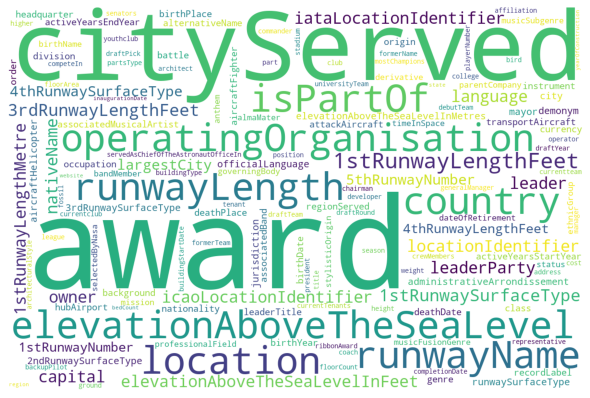

In [5]:
##################################################################
# WordCloud for Verbs
##################################################################

# Combine all the words in the column into a single string
all_text = ' '.join(df['input_vrb'].unique().tolist())

# Generate the word cloud
wordcloud = WordCloud(width=1200, height=800, background_color='white', min_font_size=10).generate(all_text)

# Display the word cloud
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()



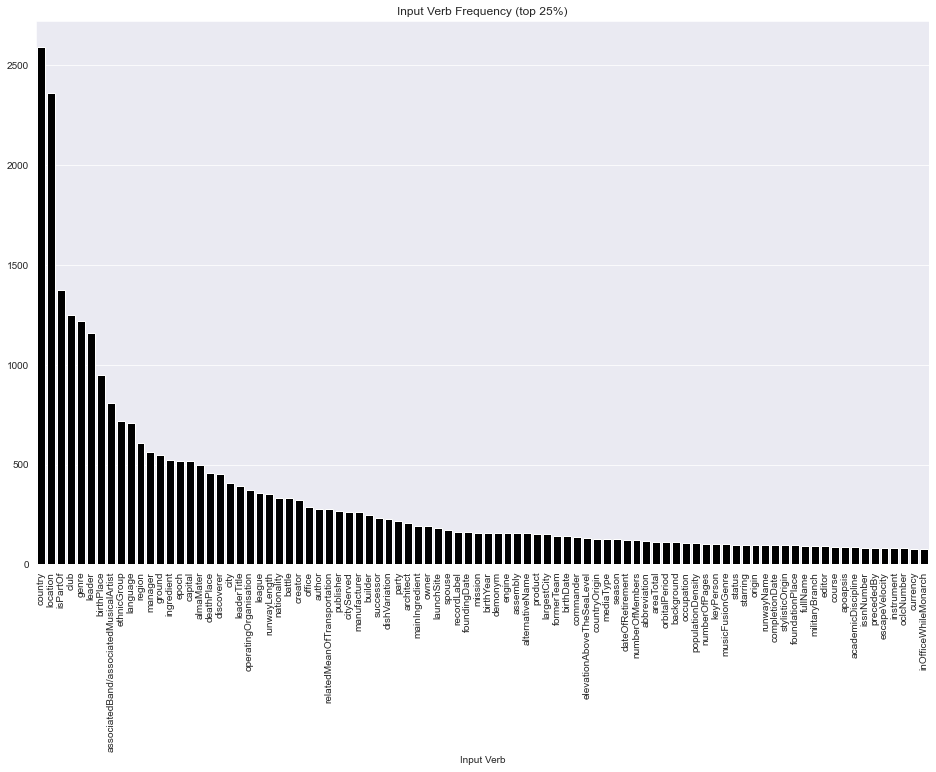

In [6]:

##################################################################
# Distribution of Input Verbs
##################################################################
# plot the distribution 
sns.set_style('darkgrid')
plt.figure(figsize=(16, 10))

# make a sorted countplot of the input_vrb column
input_vrb_counts = df['input_vrb'].value_counts()
top_input_vrbs = input_vrb_counts.iloc[:int(len(input_vrb_counts)*0.25)].index

# Create the count plot using Seaborn
ax = sns.countplot(x="input_vrb", data=df, order=top_input_vrbs, color="black")

# Set the plot title and axis labels
ax.set(title="Input Verb Frequency (top 25%)", xlabel="Input Verb", ylabel="")

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# change x-ais label size
ax.tick_params(axis='x', labelsize=10)
# set the title
# ax.set_title('Top 25% of Input Verbs', fontsize=20)

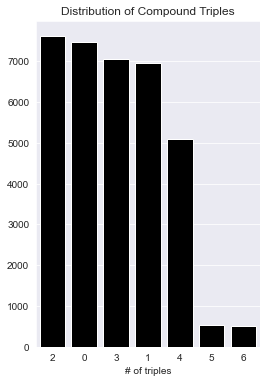

In [7]:
##################################################################
# Distribution of Compund Triples
##################################################################

df['&&_count'] = df['input_text'].apply(lambda x: x.count(' && '))
df['&&_count'].value_counts()


plt.figure(figsize=(4, 6))
ax = sns.countplot(x="&&_count", data=df, color="black", order=df["&&_count"].value_counts().index)  # Sort bars by count
ax.set(title="Distribution of Compound Triples", xlabel="# of triples", ylabel="")
plt.show()



In [8]:
train_df = pd.read_csv('./data/webNLG/webNLG2020_train.csv', index_col=[0])
train_df = train_df.iloc[:35000, :]  #hack
train_df = train_df.sample(frac=1)

# Training

In [9]:

##################################################################
# Helper Functions 
##################################################################

def progress(loss, value, max=100):
    return HTML(""" Batch loss :{loss}
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(loss=loss, value=value, max=max))

def train_model(train_df, model, tokenizer, optimizer, dev, num_of_epochs=8, batch_size=8):
    num_of_batches = len(train_df) / batch_size
    num_of_batches = int(num_of_batches)
    model.train()

    for epoch in range(1, num_of_epochs + 1):
        print(f'Running epoch: {epoch}')
        running_loss = 0
        out = display(progress(1, num_of_batches + 1), display_id=True)

        for i in range(num_of_batches):
            inputbatch, labelbatch = [], []
            new_df = train_df[i * batch_size:i * batch_size + batch_size]
            for _, row in new_df.iterrows():
                input = 'WebNLG: ' + row['input_text'] + '</s>'
                labels = row['target_text'] + '</s>'
                inputbatch.append(input)
                labelbatch.append(labels)

            inputbatch = tokenizer.batch_encode_plus(inputbatch, padding=True, max_length=400, return_tensors='pt')["input_ids"]
            labelbatch = tokenizer.batch_encode_plus(labelbatch, padding=True, max_length=400, return_tensors="pt")["input_ids"]
            inputbatch, labelbatch = inputbatch.to(dev), labelbatch.to(dev)

            optimizer.zero_grad()
            outputs = model(input_ids=inputbatch, labels=labelbatch)
            loss = outputs.loss
            loss_num = loss.item()
            logits = outputs.logits
            running_loss += loss_num
            #if i % 10 == 0:
            #    loss_per_10_steps.append(loss_num)
            out.update(progress(loss_num, i, num_of_batches + 1))

            loss.backward()
            optimizer.step()

        running_loss = running_loss / int(num_of_batches)
        print(f'Epoch: {epoch} , Running loss: {running_loss}')


##################################################################
# Process
##################################################################

if torch.cuda.is_available():
    dev = torch.device("cuda:0")
    print("Running on M1 GPU")
else:
    dev = torch.device("cpu")
    print("Running on CPU")


tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base', return_dict=True)
model.to(dev)

optimizer = Adafactor(
    model.parameters(),
    lr=1e-3,
    eps=(1e-30, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.8,
    beta1=None,
    weight_decay=0.0,
    relative_step=False,
    scale_parameter=False,
    warmup_init=False
)

train_model(train_df, model, tokenizer, optimizer, dev)



Running on CPU


C:\Users\dxrul\AppData\Roaming\Python\Python38\site-packages\transformers\models\t5\tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


Running epoch: 1


C:\Users\dxrul\AppData\Roaming\Python\Python38\site-packages\transformers\tokenization_utils_base.py:2354: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
C:\Users\dxrul\AppData\Roaming\Python\Python38\site-packages\transformers\models\t5\tokenization_t5.py:226: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
##################################################################
# Helper Functions 
##################################################################

def save_model(model, tokenizer, output_dir="trained_model"):
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

##################################################################
# Process
##################################################################

save_model(model, tokenizer, "trained_model")

shutil.make_archive("trained_model", 'zip', "trained_model")
